In [0]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import EMNIST
from torchvision.utils import make_grid

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dataset = EMNIST(root = '/', train = True, split = 'letters', transform = transforms.ToTensor(), download = True)

Extracting /EMNIST/raw/emnist.zip to /EMNIST/raw
Processing byclass


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [0]:
test_dataset = EMNIST(root = '/', train = False, split = 'letters', transform = transforms.ToTensor(), download = True)

In [5]:
input_size = 28*28
output_size = len(dataset.classes)
input_size, output_size

(784, 26)

In [17]:
random_seed = 42
torch.manual_seed(random_seed)

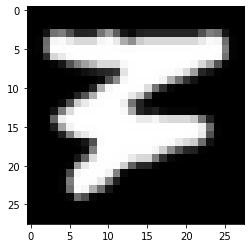

In [20]:
image, label = dataset[0]
plt.imshow(image[0, :, :], cmap = 'gray')

In [42]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(119800, 5000)

In [0]:
batch_size = 128

In [0]:
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)

In [0]:
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)

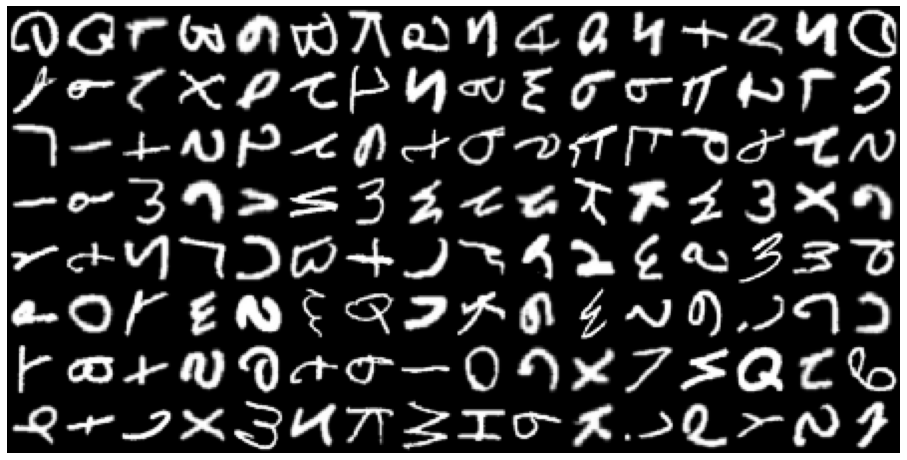

In [46]:
for images, _ in train_loader:
  plt.figure(figsize = (16, 16))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 16, padding = 0).permute(1, 2, 0))
  break

In [47]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [0]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [0]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, self.device)

In [0]:
train_ddl = DeviceDataLoader(train_loader, device)
val_ddl = DeviceDataLoader(val_loader, device)
test_ddl = DeviceDataLoader(test_loader, device)

In [0]:
def find_accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim =1)
  return ((preds == labels).sum()).item() / len(preds)

In [0]:
class EMNIST(nn.Module):
  def training_batch(self, batch):
    images, labels = batch
    outputs = self.forward(images)
    loss = F.cross_entropy(outputs, labels)
    return loss

  def validation_batch(self, batch):
    images, labels = batch
    outputs = self.forward(images)
    loss = F.cross_entropy(outputs, labels).item()
    accuracy = find_accuracy(outputs, labels)
    return {'val_loss' : loss, 'val_accuracy' : accuracy}

  def validation_end_epoch(self, outputs):
    epoch_loss = sum([x['val_loss'] for x in outputs]) / len(outputs)
    epoch_accuracy = sum([x['val_accuracy'] for x in outputs]) / len(outputs)
    return {'epoch_loss' : epoch_loss, 'epoch_accuracy' : epoch_accuracy}

In [0]:
class CNN_EMNIST(EMNIST):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size = 3, stride = 1, padding = 1, bias = True),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Conv2d(8, 8, kernel_size = 3, stride = 1, padding = 1, bias = True),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.MaxPool2d(2, 2), # 16*14*14

        nn.Conv2d(8, 64, kernel_size = 3, stride = 1, padding = 1, bias = True),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1, bias = True),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.MaxPool2d(2, 2), # 256*7*7

        nn.Flatten(),
        nn.Linear(64*7*7, 512),
        nn.ReLU(),
        nn.Linear(512, 32),
        nn.ReLU(),
        nn.Linear(32, 26)
    )

  def forward(self, images):
    return self.network(images)

In [67]:
model = CNN_EMNIST()
to_device(model, device)

CNN_EMNIST(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten()
    (15): Linear(in_features=3136, out_features=512, bias=True)
    (16): ReLU()
    (17): Linear(in_features=512, out_features=32, bias=True)
    (18): ReLU()
    (19): Linear(in_features=32, out_features=26, bias=True)
  )
)

In [0]:
def validate(model, val_ddl):
  with torch.no_grad():
    model.eval()
    outputs = [model.validation_batch(batch) for batch in val_ddl]
    return model.validation_end_epoch(outputs)

def fit(model, epochs, learning_rate, train_ddl, val_ddl, optimization_func = torch.optim.SGD):
  history = []
  optimizer = optimization_func(model.parameters(), learning_rate)
  for epoch in range(epochs):
    model.train()
    for batch in train_ddl:
      loss = model.training_batch(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = validate(model, val_ddl)
    history.append(result)
    print('Epoch: {}, Validation loss: {:.5f}, Validation accuracy: {:.5f}'.format(epoch, result['epoch_loss'], result['epoch_accuracy']))
  return history

In [69]:
history = [validate(model, val_ddl)]
history

[{'epoch_accuracy': 0.03046875, 'epoch_loss': 3.264285171031952}]

In [70]:
history += fit(model, 5, 0.001, train_ddl, val_ddl, torch.optim.Adam)

Epoch: 0, Validation loss: 0.52595, Validation accuracy: 0.87344
Epoch: 1, Validation loss: 0.44755, Validation accuracy: 0.89062
Epoch: 2, Validation loss: 0.41448, Validation accuracy: 0.89531
Epoch: 3, Validation loss: 0.38481, Validation accuracy: 0.90547
Epoch: 4, Validation loss: 0.38190, Validation accuracy: 0.90137


In [71]:
history += fit(model, 5, 0.0003, train_ddl, val_ddl, torch.optim.Adam)

Epoch: 0, Validation loss: 0.34932, Validation accuracy: 0.90410
Epoch: 1, Validation loss: 0.34818, Validation accuracy: 0.90449
Epoch: 2, Validation loss: 0.35086, Validation accuracy: 0.90898
Epoch: 3, Validation loss: 0.35291, Validation accuracy: 0.90703
Epoch: 4, Validation loss: 0.35915, Validation accuracy: 0.90781


In [72]:
history += fit(model, 5, 0.0001, train_ddl, val_ddl, torch.optim.Adam)

Epoch: 0, Validation loss: 0.33816, Validation accuracy: 0.90723
Epoch: 1, Validation loss: 0.33500, Validation accuracy: 0.90977
Epoch: 2, Validation loss: 0.31318, Validation accuracy: 0.90664
Epoch: 3, Validation loss: 0.33488, Validation accuracy: 0.90137
Epoch: 4, Validation loss: 0.33095, Validation accuracy: 0.91113


In [73]:
history += fit(model, 5, 0.00003, train_ddl, val_ddl, torch.optim.Adam)

Epoch: 0, Validation loss: 0.36051, Validation accuracy: 0.90781
Epoch: 1, Validation loss: 0.34244, Validation accuracy: 0.90781
Epoch: 2, Validation loss: 0.33485, Validation accuracy: 0.90781
Epoch: 3, Validation loss: 0.33221, Validation accuracy: 0.90801
Epoch: 4, Validation loss: 0.33781, Validation accuracy: 0.90742


Text(0.5, 1.0, 'Accuracy vs No. of Epochs')

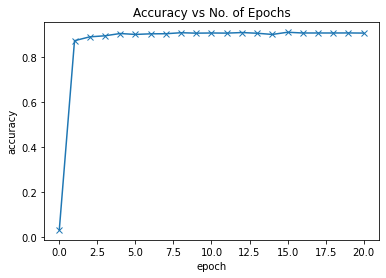

In [74]:
accuracies = [x['epoch_accuracy'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of Epochs')

In [75]:
validate(model, test_ddl)

{'epoch_accuracy': 0.9061541411042945, 'epoch_loss': 0.3345767958946755}